# Electricity generation of world regions

This notebooks details the data preparation and plotting of chart showing electricity generation and electricity generation per capita of the main world regions: world, EU, USA, China, India and rest of the world.

## Load prerequisities

This notebooks uses the Tidyverse libraries, the `readxl` package to read Excel files. To install these libraries, run the command `install.packages(c("readxl", "tidyverse"))` in your R instance. We also specify paths to the relevant pre-downloaded datasets here.

In [3]:
Sys.setlocale("LC_ALL", "cs_CZ.UTF-8")
library(tidyverse)
library(readxl)

DATASET_PATH_ELECTRICITY <- "../data/ember/yearly_full_release_long_format.csv"
DATASET_PATH_POPULATION <- "../data/un/WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx"


[1] "cs_CZ.UTF-8/cs_CZ.UTF-8/cs_CZ.UTF-8/C/cs_CZ.UTF-8/C"

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”
Warning message:
“package ‘stringr’ was built under R version 4.2.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Next, we predefine a fill scale for generation categories (coal, renewables, etc.) in order to make updates easier.

In [4]:
scale_fill_source_category <- function(...) {
  scale_fill_manual(
    values = c(
      "Nuclear" = "#8395a7",
      "Coal" = "#ed4c67",
      "Natural Gas" = "#b53471",
      "Other Fossil Fuels" = "#833471",
      "Wind" = "#34cccd",
      "Solar" = "#ffc312",
      "Bioenergy" = "#00c78b",
      "Hydro" = "#3993dd"
    ),
    ...
  )
}


## Electricity generation data

For this visualization, we use the electricity generation data from the [Ember yearly electricity dataset](https://ember-climate.org/data-catalogue/yearly-electricity-data/). The "Yearly Full Release Long Format" CSV file was downloaded into `/data/ember/yearly_full_release_long_format.csv`. The dataset is described as follows:

> The dataset contains yearly electricity generation, capacity, emissions, import and demand data for over 200 geographies. Data is collected from multi-country datasets (EIA, Eurostat, BP, UN) as well as national sources (e.g China data from the National Bureau of Statistics).

As we will need only electricity generation data for our analysis and only some regions, we first need to filter the dataset accordingly. For the purpose of the visualization, we will also add two new columns: ValueTWh and GenerationCategory.

In [5]:
electricity_world <- DATASET_PATH_ELECTRICITY |>
  read_csv(
    # Select only columns relevant for our analysis.
    col_select = c("Area", "ISO 3 code", "Year", "Category", "Variable", "Value", "Unit", "EU"),
    show_col_types = FALSE
  ) |>
  # Filter electricity generation and TWh unit.
  filter(
    Area == "World" | EU == 1 | `ISO 3 code` %in% c("CHN", "IND", "USA"),
    Category %in% c("Electricity generation"),
    Unit == "TWh"
  ) |>
  select(
    Area = "Area",
    CountryCode = `ISO 3 code`,
    Year,
    Variable,
    ValueTWh = Value,
    EU
  ) |>
  mutate(
    GenerationCategory = case_match(
      Variable,
      "Nuclear" ~ "Nuclear",
      "Coal" ~ "Coal",
      "Gas" ~ "Natural Gas",
      "Other Fossil" ~ "Other Fossil Fuels",
      "Wind" ~ "Wind",
      "Solar" ~ "Solar",
      "Bioenergy" ~ "Bioenergy",
      "Hydro" ~ "Hydro"
    ),
    CountryCode = case_match(
      Area,
      "World" ~ "WLD",
      .default = CountryCode
    )
  ) |>
  filter(!is.na(GenerationCategory)) |>
  summarise(
    ValueTWh = sum(ValueTWh),
    .by = c(CountryCode, Year, GenerationCategory, EU)
  )


We now have the table of annual electricity generation per country and energy source category in a long format:

In [6]:
head(electricity_world)


CountryCode,Year,GenerationCategory,EU,ValueTWh
<chr>,<dbl>,<chr>,<dbl>,<dbl>
AUT,2000,Bioenergy,1,1.53
AUT,2000,Coal,1,5.72
AUT,2000,Natural Gas,1,7.85
AUT,2000,Hydro,1,41.84
AUT,2000,Nuclear,1,0.00
AUT,2000,Other Fossil Fuels,1,2.63


## Population data

As we want to visualize electricity generation trends per capita, we also use the population data from the [UN demographic indicators dataset](https://population.un.org/wpp/). The "Compact (most used: estimates and medium projections)" XLSX file was downloaded into `/data/un/WPP2024_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT.xlsx`. The dataset is described as follows:

> The dataset contains yearly population estimates and projections that have been prepared by the Population Division of the Department of Economic and Social Affairs of the United Nations Secretariat. It presents population estimates from 1950 to the present for 237 countries or areas.

As we will need only need countries’ pouplation data in a period of 2000–2024 for our analysis, we first need to tidy and filter the dataset accordingly.

In [ ]:
population_og <- read_xlsx(
    DATASET_PATH_POPULATION,
    sheet = "Estimates",
    skip = 16,
    col_types = "text"
  ) |>
  # Select only columns relevant for our analysis.
  select(
    CountryNameEn = 3,
    CountryCode = 6,
    Year = 11,
    Population = 12
  ) |>
  transmute(
    CountryCode,
    CountryNameEn,
    Year = as.integer(Year),
    # Scale population data to millions (from thousands) in order to make
    # the numbers more readable and calculations below easier.
    PopulationMn = as.numeric(Population) / 1000
  ) |>
  mutate(CountryCode = case_match(
          CountryNameEn,
          "World" ~ "WLD",
          .default = CountryCode
    )) |>
  filter(between(Year, 2000, 2024))

# Filter the 2023 row.
row_2023 <- population_og[population_og$Year == 2023, ]

# Modify the year to 2024.
row_2024 <- row_2023
row_2024$Year <- 2024

# Append the new row to the original dataframe.
population <- rbind(population_og, row_2024)


Warning message:
“There was 1 warning in `transmute()`.
ℹ In argument: `PopulationMn = as.numeric(Population)/1000`.
Caused by warning:
! NAs introduced by coercion”


We now have the table of annual population per country in a long format:

## Data wrangling

Now, we will join the electricity generation and population datasets together and add a new column containing electricity generation per capita.

In [8]:
# Join the datasets and reorder generation category.
electricity_population_world <- electricity_world |>
  left_join(population, join_by(CountryCode, Year)) |>
  mutate(
    # TWh / (1 million people) = MWh / (1 person) = kWh / (1 person) / 1000
    ValuekWhPerCapita = ValueTWh / PopulationMn * 1000,
    GenerationCategory = factor(GenerationCategory, 
      levels = c("Hydro",
              "Bioenergy",
              "Solar",
              "Wind",
              "Other Fossil Fuels",
              "Natural Gas",
              "Coal",
              "Nuclear"))
    )

head(electricity_population_world)
head(filter(electricity_population_world, is.na(CountryNameEn)))


CountryCode,Year,GenerationCategory,EU,ValueTWh,CountryNameEn,PopulationMn,ValuekWhPerCapita
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
AUT,2000,Bioenergy,1,1.53,Austria,8.003663,191.1625
AUT,2000,Coal,1,5.72,Austria,8.003663,714.6728
AUT,2000,Natural Gas,1,7.85,Austria,8.003663,980.8009
AUT,2000,Hydro,1,41.84,Austria,8.003663,5227.6064
AUT,2000,Nuclear,1,0.00,Austria,8.003663,0.0000
AUT,2000,Other Fossil Fuels,1,2.63,Austria,8.003663,328.5995


CountryCode,Year,GenerationCategory,EU,ValueTWh,CountryNameEn,PopulationMn,ValuekWhPerCapita
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>


Now, we have to calculate EU-27 total and calculate electricity generation of rest of the world.

In [9]:
electricity_population_eu27 <- electricity_population_world |>
  # The UK is not part of EU27.
  filter(EU == 1) |>
  mutate(CountryCode = "EU27") |>
  summarise(
    ValueTWh = sum(ValueTWh),
    PopulationMn = sum(PopulationMn),
    .by = c(CountryCode, Year, GenerationCategory)
  ) |>
  mutate(
    ValuekWhPerCapita = ValueTWh / PopulationMn * 1000,
    .after = PopulationMn
  ) |>
  mutate(CountryNameEn = "EU-27")


In [ ]:
# Now, we need to calculate rest of the world data by subtracting EU-27, China, India and USA data from world data.

regions_to_subtract <- c("EU27", "USA", "CHN", "IND")

electricity_to_subtract <- bind_rows(electricity_population_world, electricity_population_eu27) |>
  filter(CountryCode %in% regions_to_subtract) |>
  group_by(Year, GenerationCategory) |>
  summarise(
    ValueTWh_regions   = sum(ValueTWh,   na.rm = TRUE),
    PopulationMn_regions = sum(PopulationMn, na.rm = TRUE),
    .groups = "drop"
  )

electricity_population_row <- electricity_population_world |>
  filter(CountryCode == "WLD") |>
  select(Year, GenerationCategory, ValueTWh_world = ValueTWh, PopulationMn_world = PopulationMn) |>
  left_join(electricity_to_subtract, by = c("Year", "GenerationCategory")) |>
  mutate(
    ValueTWh = ValueTWh_world - coalesce(ValueTWh_regions, 0),
    PopulationMn = PopulationMn_world - coalesce(PopulationMn_regions, 0),
    CountryCode = "ROW",
    CountryNameEn = "Rest of the World",
    # kWh per capita recomputed to stay consistent
    ValuekWhPerCapita = ValueTWh / PopulationMn * 1000) |>
  select(CountryCode, Year, GenerationCategory, ValueTWh, PopulationMn, ValuekWhPerCapita, CountryNameEn)

# Add EU-27 and RoW rows back to your data.
electricity_regions <- bind_rows( filter(electricity_population_world, CountryCode %in% c("USA", "CHN", "IND", "WLD"), is.na(EU) | EU != 1),
                                  electricity_population_eu27,
                                  electricity_population_row) |>
                                  select(-EU) |>
# Add a column with country names in Czech.
  mutate(
    CountryNameCs = countrycode::countrycode(
      CountryCode,
      origin = "iso3c",
      destination = "cldr.name.cs",
      custom_match = c("EU27" = "Evropská unie", "ROW" = "Ostatní státy", "WLD" = "Celý svět")
    ),
    .after = CountryNameEn
  )

## Generating small multiples

We will now plot two area charts for each region depicting electricity generation (and electricity generation per capita) and per energy source in a period of 2000–2024. We will do so in a single infographic, a visualization type commonly known as *small multiples*.

### Electricity generation

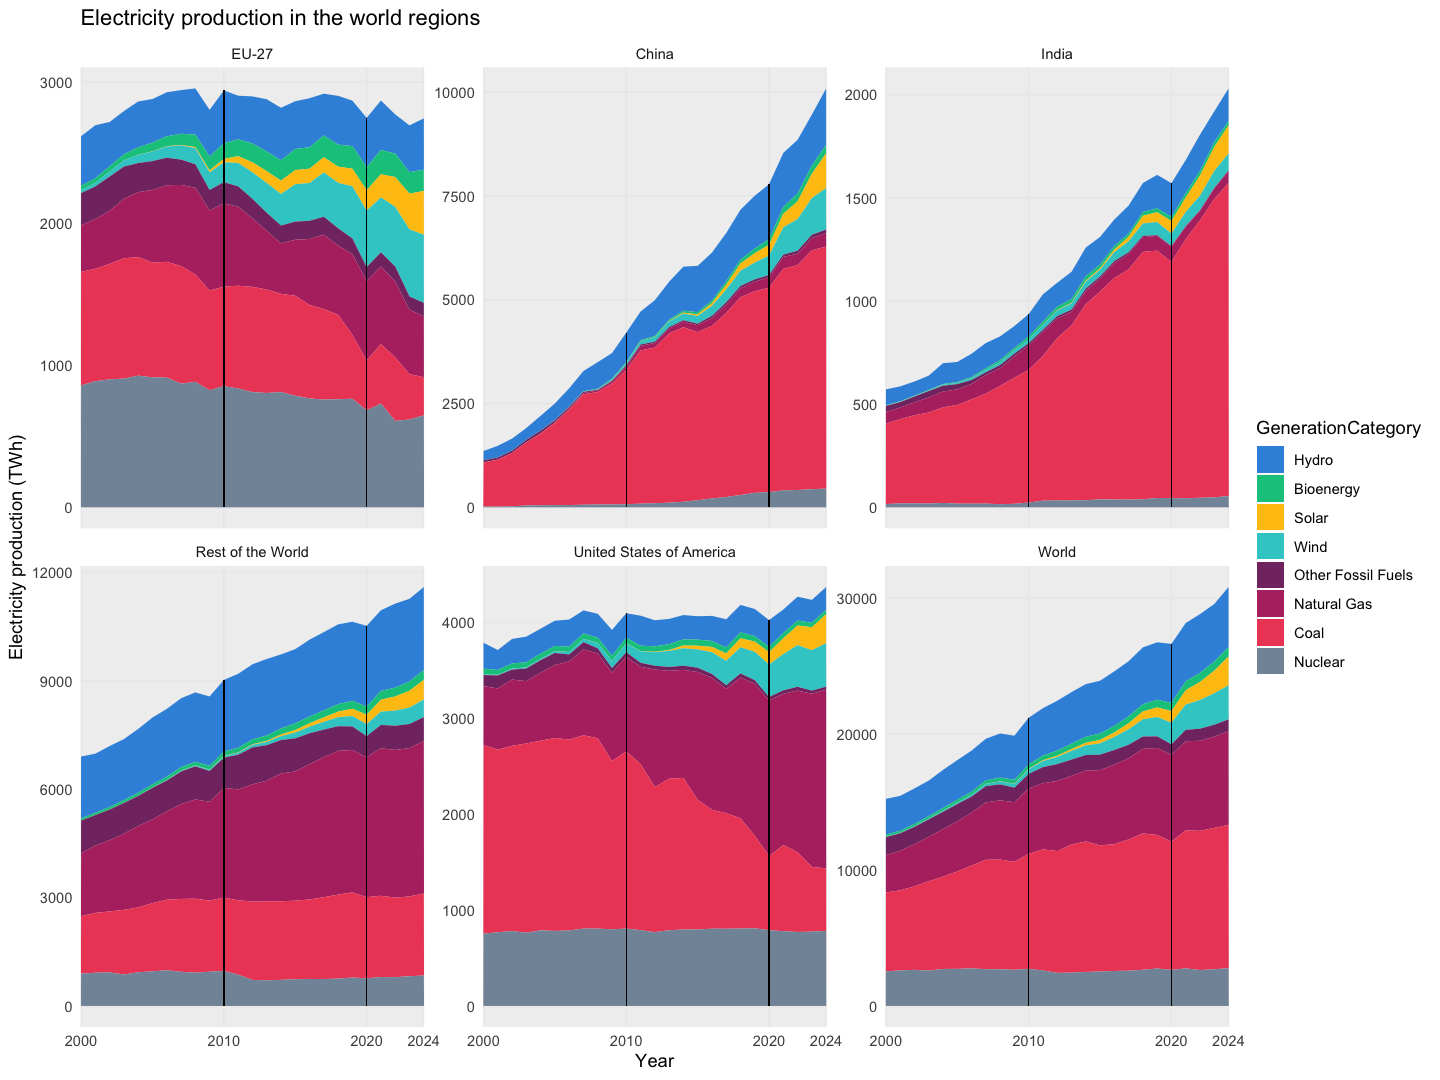

In [11]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with English annotations.
electricity_regions |>
  ggplot(aes(x = Year, y = ValueTWh)) +
  geom_area(aes(fill = GenerationCategory)) +
  geom_col(
    data = ~ filter(.x, Year %in% c(2010, 2020)),
    width = 0.1,
    fill = "black"
  ) +
  scale_fill_source_category() +
  scale_x_continuous(
    "Year",
    breaks = c(2000, 2010, 2020, 2024),
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    "Electricity production (TWh)"
  ) +
  ggtitle("Electricity production in the world regions") +
  facet_wrap(vars(CountryNameEn), ncol = 3, scales = "free_y") +
  theme_minimal() +
  theme(
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")
  )

# Save plot in an svg file.
ggsave("../outputs/electricity-regions-en.svg", width = 26.7, height = 16.7)


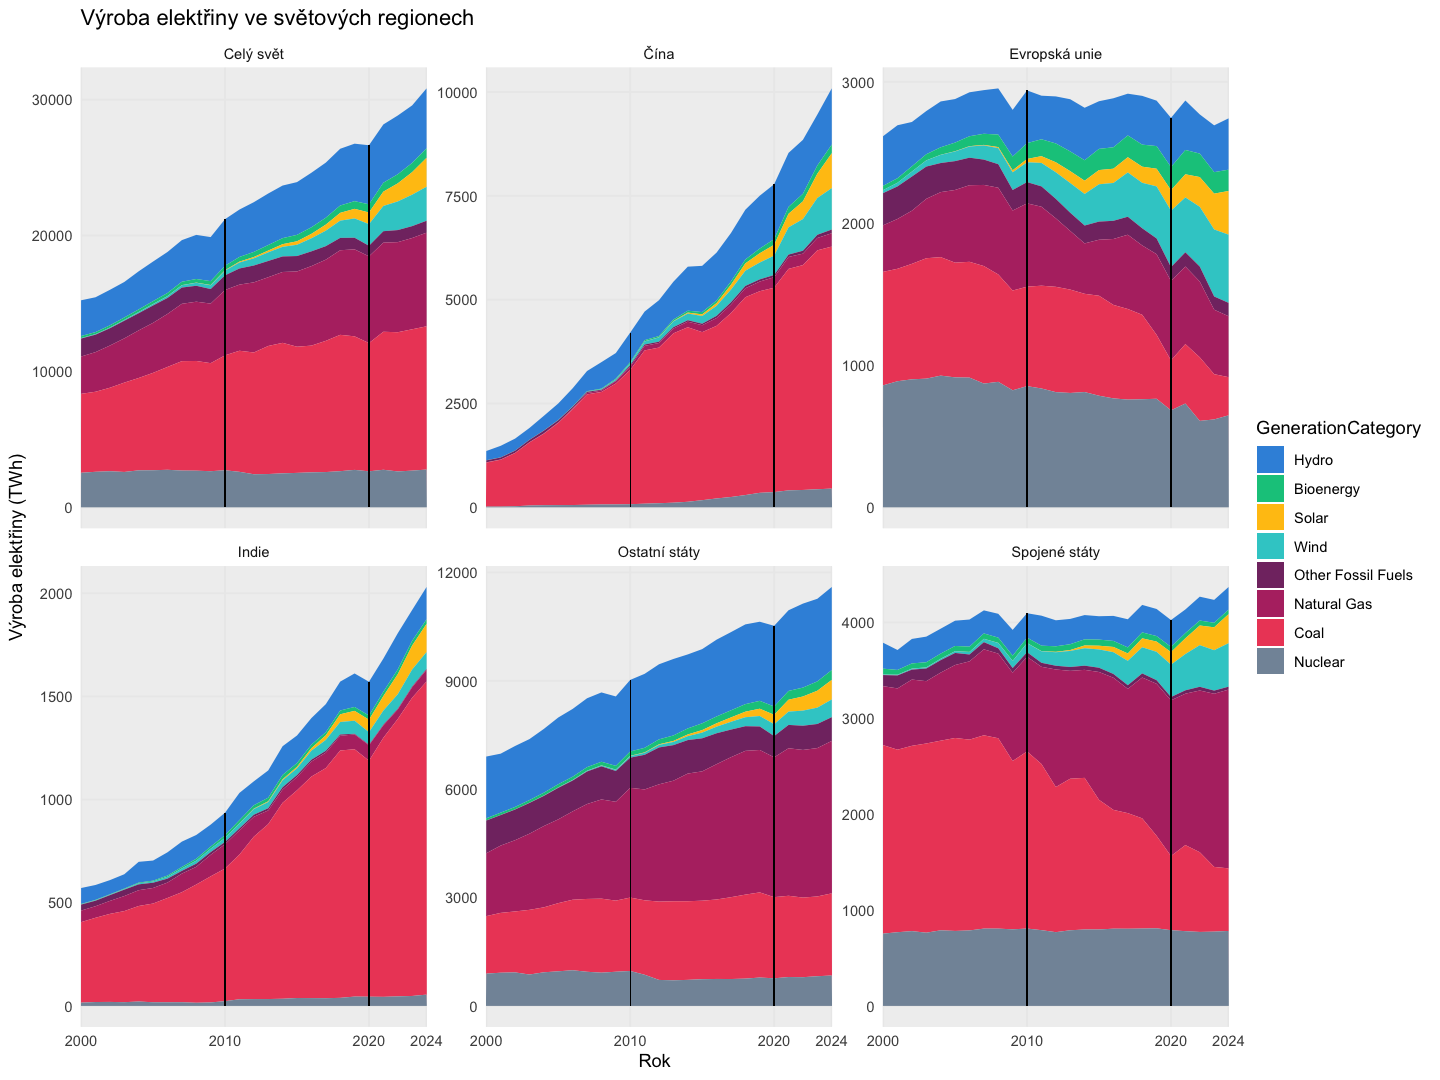

In [12]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with Czech annotations.
electricity_regions |>
  ggplot(aes(x = Year, y = ValueTWh)) +
  geom_area(aes(fill = GenerationCategory)) +
  geom_col(
    data = ~ filter(.x, Year %in% c(2010, 2020)),
    width = 0.1,
    fill = "black"
  ) +
  scale_fill_source_category() +
  scale_x_continuous(
    "Rok",
    breaks = c(2000, 2010, 2020, 2024),
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    "Výroba elektřiny (TWh)"
  ) +
  ggtitle("Výroba elektřiny ve světových regionech") +
  facet_wrap(vars(CountryNameCs), ncol = 3, scales = "free_y") +
  theme_minimal() +
  theme(
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")
  )

# Save plot in an svg file.
ggsave("../outputs/electricity-regions-cs.svg", width = 26.7, height = 16.7)


### Electricity generation per capita

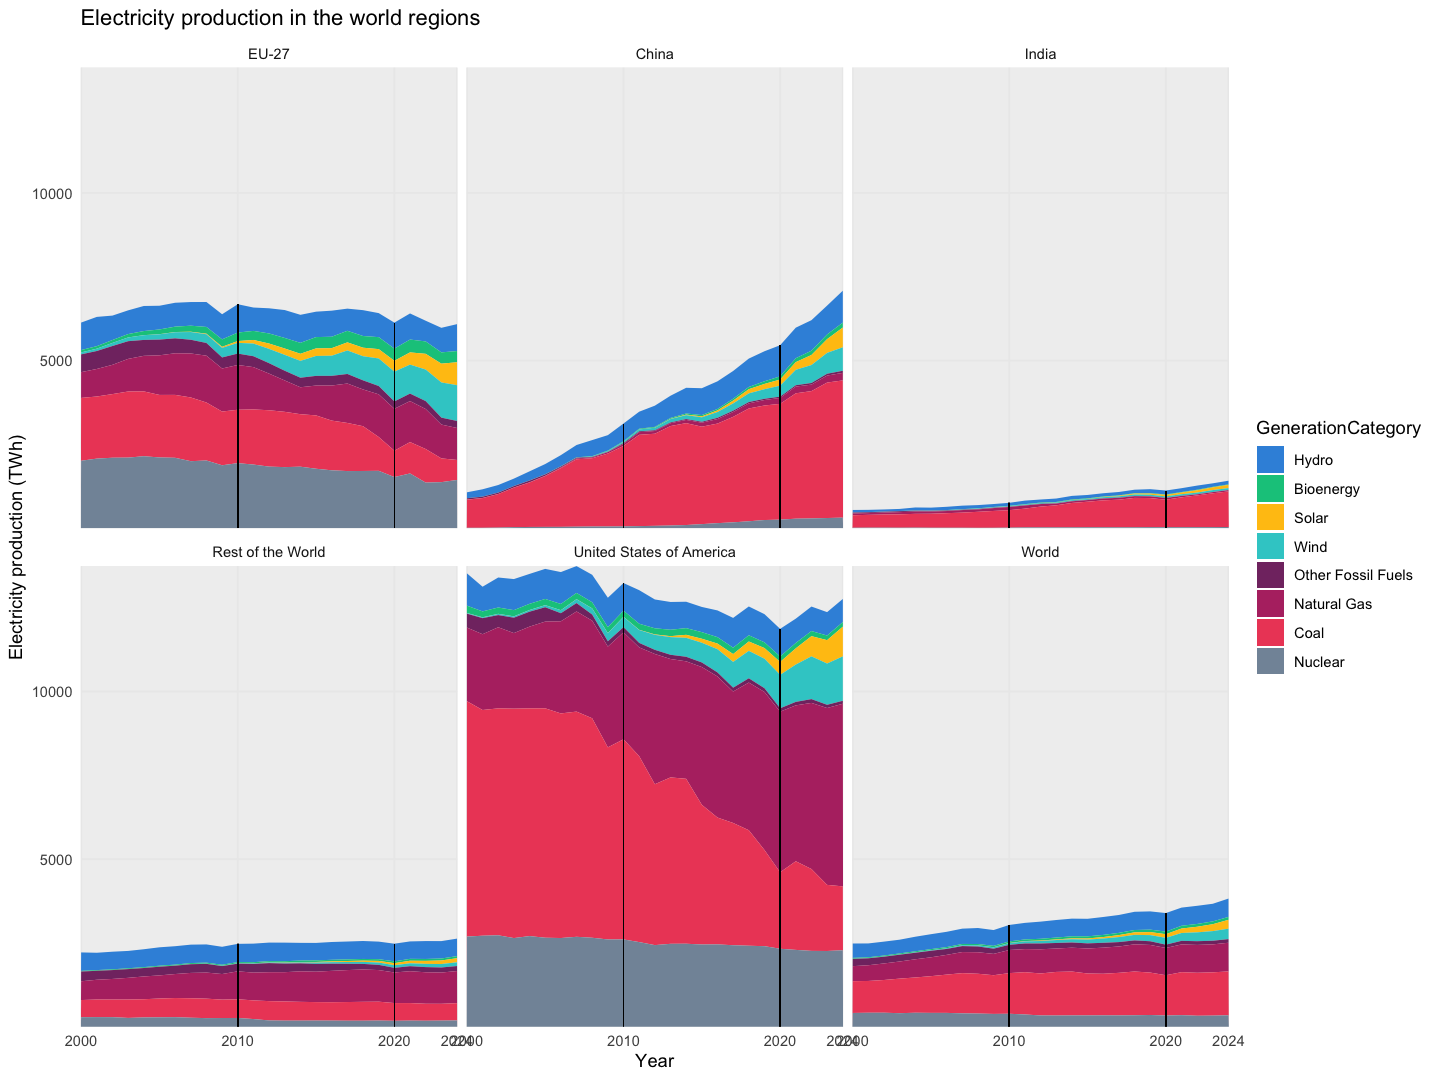

In [13]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with English annotations.
electricity_regions |>
  ggplot(aes(x = Year, y = ValuekWhPerCapita)) +
  geom_area(aes(fill = GenerationCategory)) +
  geom_col(
    data = ~ filter(.x, Year %in% c(2010, 2020)),
    width = 0.1,
    fill = "black"
  ) +
  scale_fill_source_category() +
  scale_x_continuous(
    "Year",
    breaks = c(2000, 2010, 2020, 2024),
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    "Electricity production (TWh)",
    breaks = c(5000, 10000, 15000),
    expand = c(0, 0)
  ) +
  ggtitle("Electricity production in the world regions") +
  facet_wrap(vars(CountryNameEn), ncol = 3) +
  theme_minimal() +
  theme(
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")
  )

# Save plot in an svg file.
ggsave("../outputs/per-capita-electricity-regions-en.svg", width = 26.7, height = 16.7)

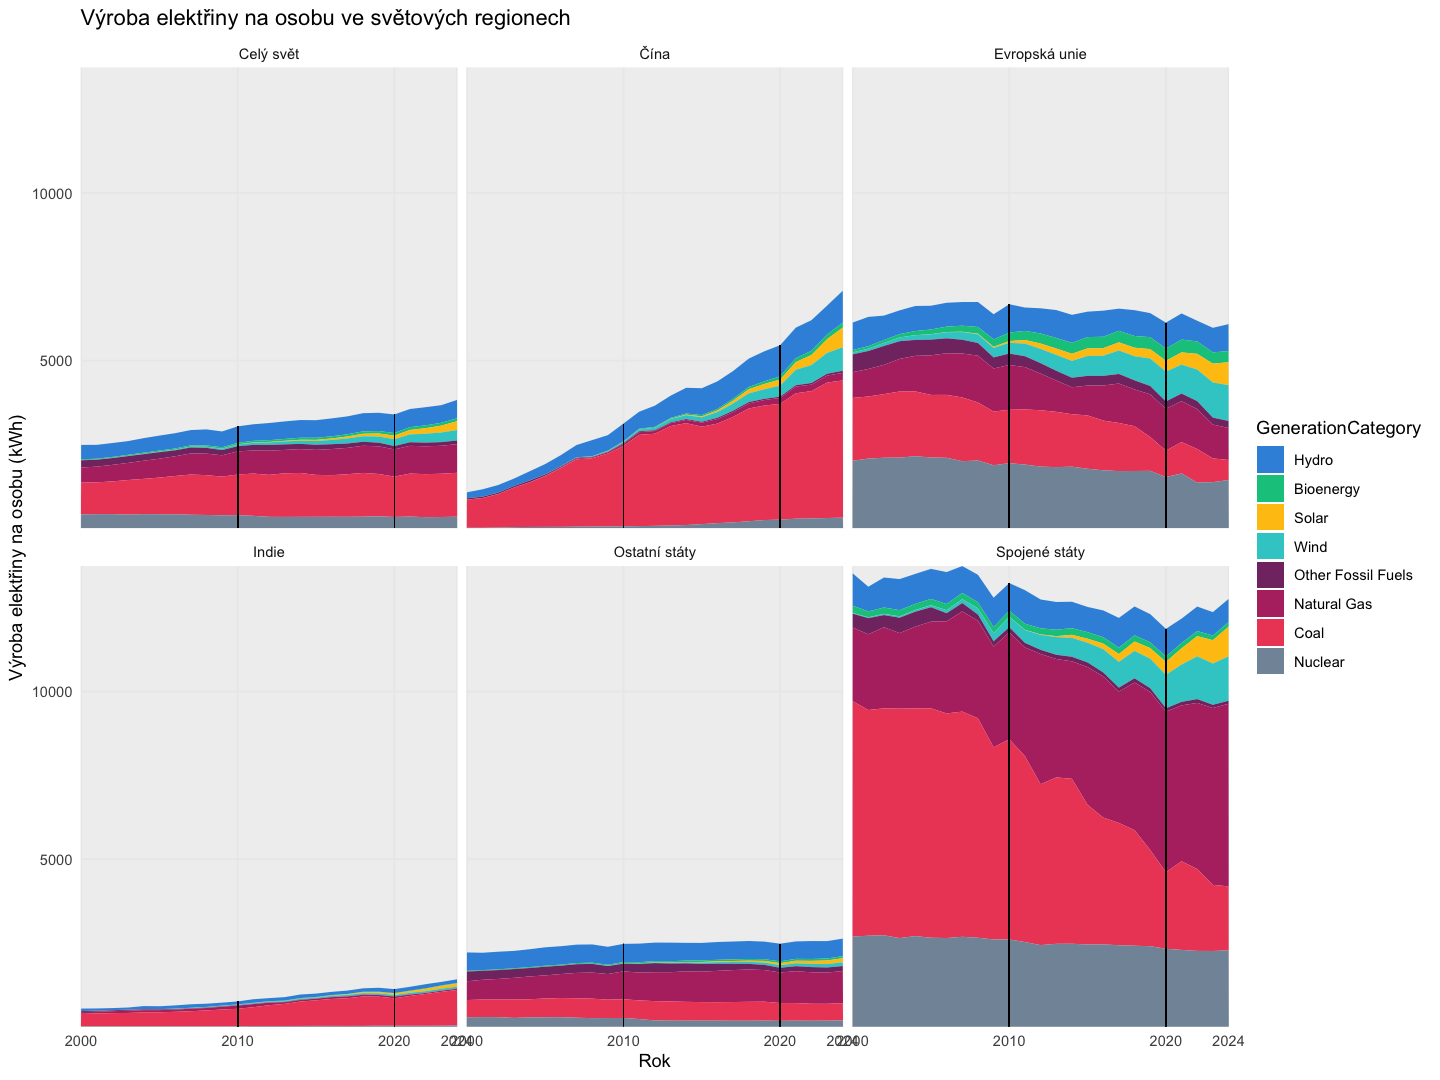

In [14]:
options(repr.plot.width = 12, repr.plot.height = 9)

# Generate a chart with Czech annotations.
electricity_regions |>
  ggplot(aes(x = Year, y = ValuekWhPerCapita)) +
  geom_area(aes(fill = GenerationCategory)) +
  geom_col(
    data = ~ filter(.x, Year %in% c(2010, 2020)),
    width = 0.1,
    fill = "black"
  ) +
  scale_fill_source_category() +
  scale_x_continuous(
    "Rok",
    breaks = c(2000, 2010, 2020, 2024),
    expand = c(0, 0)
  ) +
  scale_y_continuous(
    "Výroba elektřiny na osobu (kWh)",
    breaks = c(5000, 10000, 15000),
    expand = c(0, 0)
  ) +
  ggtitle("Výroba elektřiny na osobu ve světových regionech") +
  facet_wrap(vars(CountryNameCs), ncol = 3) +
  theme_minimal() +
  theme(
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill = "#f0f0f0", color = "#f0f0f0")
  )

# Save plot in an svg file.
ggsave("../outputs/per-capita-electricity-regions-cs.svg", width = 26.7, height = 16.7)

## Data for accompanying text

The following code generates data mentioned in the infographic and the accompanying text:
* Share of global electricity generation by the selected regions.
* Electricity generation in the first and last data year.
* Electricity generation per capita in the first and last data year.

In [17]:
electricity_regions |>
  filter(Year == max(Year)) |>
  select(CountryNameEn, Year, GenerationCategory, ValueTWh) |>
  group_by(CountryNameEn, Year) |>
  summarise(
    ValueTWh   = sum(ValueTWh,   na.rm = TRUE),
    .groups = "drop"
  ) |>
  mutate(Share = (ValueTWh / ValueTWh[CountryNameEn == "World"]) * 100)

CountryNameEn,Year,ValueTWh,Share
<chr>,<dbl>,<dbl>,<dbl>
China,2024,10086.88,32.722763
EU-27,2024,2742.36,8.896467
India,2024,2030.20,6.586155
Rest of the World,2024,11596.22,37.619200
United States of America,2024,4369.61,14.175415
World,2024,30825.27,100.000000


In [16]:
electricity_regions |>
  filter(Year %in% c(min(Year), max(Year))) |>
  select(CountryNameEn, Year, GenerationCategory, ValueTWh, ValuekWhPerCapita) |>
  group_by(CountryNameEn, Year) |>
  summarise(
    ValueTWh   = sum(ValueTWh,   na.rm = TRUE),
    ValuekWhPerCapita = sum(ValuekWhPerCapita, na.rm = TRUE),
    .groups = "drop"
  )

CountryNameEn,Year,ValueTWh,ValuekWhPerCapita
<chr>,<dbl>,<dbl>,<dbl>
China,2000,1355.60,1071.8519
China,2024,10086.88,7082.1853
EU-27,2000,2616.88,6133.5478
EU-27,2024,2742.36,6086.4997
India,2000,571.39,545.2181
India,2024,2030.20,1418.0316
Rest of the World,2000,6903.16,2219.7085
Rest of the World,2024,11596.22,2631.0185
United States of America,2000,3788.01,13524.0879
